# PCL Coursework

### Installing Libraries

In [1]:
import sys

!{sys.executable} -m pip install -r ../requirements.txt

  Using cached torch-2.10.0-2-cp310-none-macosx_11_0_arm64.whl (79.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 30.3 MB/s eta 0:00:0000:010:01
  Using cached tqdm-4.67.3-py3-none-any.whl (78 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.6 MB/s eta 0:00:0000:01
  Using cached filelock-3.24.3-py3-none-any.whl (24 kB)
  Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
  Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Using cached fsspec-2026.2.0-py3-none-any.whl (202 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
  Using cached safetensors-0.7.0-cp38-abi3-macosx_11_0_arm64.whl (447 kB)
  Using cached pyyaml-6.0.3-cp310-cp310-macosx_11_0_arm64.whl (174 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.7/288.7 KB 39.4 MB/s eta 0:00:00
  Using cached typer_slim-0.24.0-py3-none-any.whl (3.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.3 MB/s eta 0:00:00a 0:00:01
  Using cached huggingface_hub-1.4.1-py3-none-any.w

### Imports

In [2]:
import re, io, ast
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Acquisition, Exploration, and Preprocessing 

### Loading Main Dataset

In [ ]:
def load_pcl_tsv(path):
    lines = Path(path).read_text(encoding="utf-8", errors="replace").splitlines()
    start = 0
    for i, line in enumerate(lines):
        if re.match(r"^\d+\t", line):  # first real data row starts with an integer id and tab
            start = i
            break

    data = "\n".join(lines[start:])
    cols = ["par_id","art_id","keyword","country_code","text","label"]
    return pd.read_csv(io.StringIO(data), sep="\t", names=cols, quoting=3)

pcl = load_pcl_tsv("../data/dontpatronizeme_pcl.tsv")
pcl.head()

,par_id,art_id,keyword,country_code,text,label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0


### Shape and Label Distribution

In [4]:
pcl.shape, pcl["label"].value_counts().sort_index()

((10469, 6),
 label
 0    8529
 1     947
 2     144
 3     458
 4     391
 Name: count, dtype: int64)

In [5]:
pcl["bin_label"] = (pcl["label"] >= 2).astype(int)
pcl["bin_label"].value_counts().rename(index={0: "0-1 non-PCL", 1: "2-4 PCL"})

bin_label
0-1 non-PCL    9476
2-4 PCL         993
Name: count, dtype: int64

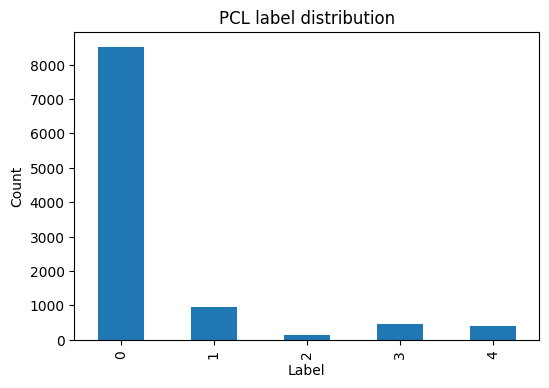

In [ ]:
label_counts = pcl["label"].value_counts().sort_index()

plt.figure(figsize=(6,4))
label_counts.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("PCL label distribution")
plt.show()

### Text Length

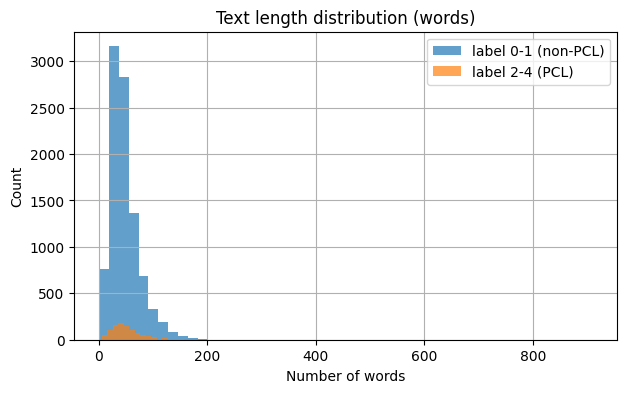

,n_words,n_chars
count,10469.000000,10469.000000
mean,48.422581,267.583150
std,29.091174,160.209018
min,1.000000,3.000000
25%,30.000000,169.000000
50%,42.000000,233.000000
75%,60.000000,330.000000
max,909.000000,5501.000000


In [7]:
pcl["n_chars"] = pcl["text"].astype(str).str.len()
pcl["n_words"] = pcl["text"].astype(str).str.split().apply(len)

plt.figure(figsize=(7,4))
pcl.loc[pcl.label < 2, "n_words"].hist(bins=50, alpha=0.7, label="label 0-1 (non-PCL)")
pcl.loc[pcl.label >= 2, "n_words"].hist(bins=50, alpha=0.7, label="label 2-4 (PCL)")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.title("Text length distribution (words)")
plt.legend()
plt.show()

pcl[["n_words","n_chars"]].describe()

### Lexical Signal

### Discriminative Unigrams

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd

texts = pcl["text"].astype(str).to_list()
y = pcl["bin_label"].astype(int).to_numpy()

cv = CountVectorizer(max_features=12000, stop_words="english", lowercase=True, min_df=5)
X = cv.fit_transform(texts)
vocab = np.array(cv.get_feature_names_out())

pos = np.asarray(X[y == 1].sum(axis=0)).ravel()
neg = np.asarray(X[y == 0].sum(axis=0)).ravel()

pos_total = pos.sum()
neg_total = neg.sum()

# rate ratio with smoothing
rate_ratio = ((pos + 1) / (pos_total + 1)) / ((neg + 1) / (neg_total + 1))

# avoid tiny counts
mask = (pos + neg) >= 40
idx = np.argsort(rate_ratio[mask])[-15:][::-1]

top_tokens = pd.DataFrame({
    "token": vocab[mask][idx],
    "pcl_count": pos[mask][idx].astype(int),
    "nonpcl_count": neg[mask][idx].astype(int),
    "rate_ratio (PCL vs nonPCL)": np.round(rate_ratio[mask][idx], 2),
})
top_tokens

,token,pcl_count,nonpcl_count,rate_ratio (PCL vs nonPCL)
0,christmas,29,16,15.93
1,god,36,31,10.44
2,feed,19,21,8.21
3,plight,21,26,7.36
4,hope,65,106,5.57
5,hunger,15,25,5.56
6,helping,34,64,4.86
7,streets,32,61,4.81
8,kids,26,54,4.43
9,charity,26,54,4.43


### Discriminative Bigrams

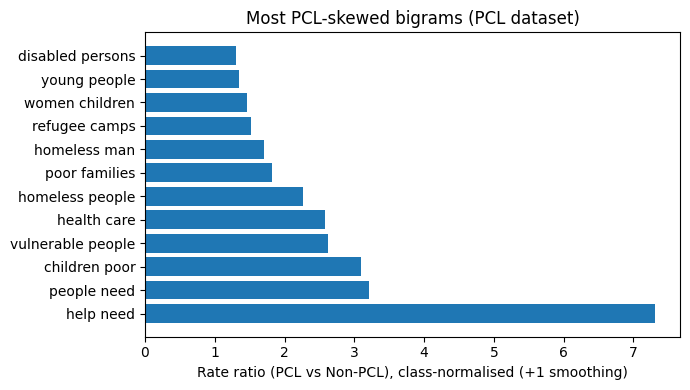

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cv2 = CountVectorizer(
    max_features=20000,
    stop_words="english",
    lowercase=True,
    ngram_range=(2, 2),
    min_df=5
)

X2 = cv2.fit_transform(texts)
vocab2 = np.array(cv2.get_feature_names_out())

pos2 = np.asarray(X2[y == 1].sum(axis=0)).ravel()
neg2 = np.asarray(X2[y == 0].sum(axis=0)).ravel()

pos2_total = pos2.sum()
neg2_total = neg2.sum()

mask2 = (pos2 + neg2) >= 40
rate_ratio2 = ((pos2 + 1) / (pos2_total + 1)) / ((neg2 + 1) / (neg2_total + 1))

topk = 12
idx2 = np.argsort(rate_ratio2[mask2])[-topk:][::-1]
bigrams = vocab2[mask2][idx2]
vals = rate_ratio2[mask2][idx2]

plt.figure(figsize=(7, 4))
plt.barh(range(len(bigrams))[::-1], vals[::-1])
plt.yticks(range(len(bigrams))[::-1], bigrams[::-1])
plt.xlabel("Rate ratio (PCL vs Non-PCL), class-normalised (+1 smoothing)")
plt.title("Most PCL-skewed bigrams (PCL dataset)")
plt.tight_layout()
plt.show()

### Load training and dev data

In [10]:
train_data = pd.read_csv("../data/train_data.csv")
dev_data = pd.read_csv("../data/dev_data.csv")

train_data.head(), dev_data.head(), train_data.shape, dev_data.shape

(   par_id                  label
 0    4341  [1, 0, 0, 1, 0, 0, 0]
 1    4136  [0, 1, 0, 0, 0, 0, 0]
 2   10352  [1, 0, 0, 0, 0, 1, 0]
 3    8279  [0, 0, 0, 1, 0, 0, 0]
 4    1164  [1, 0, 0, 1, 1, 1, 0],
    par_id                  label
 0    4046  [1, 0, 0, 1, 0, 0, 0]
 1    1279  [0, 1, 0, 0, 0, 0, 0]
 2    8330  [0, 0, 1, 0, 0, 0, 0]
 3    4063  [1, 0, 0, 1, 1, 1, 0]
 4    4089  [1, 0, 0, 0, 0, 0, 0],
 (8375, 2),
 (2094, 2))

### Parse Multi-label Vectors

In [11]:
def parse_labels(label_str):
    s = str(label_str).strip()
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return v
    except Exception:
        pass
    parts = re.split(r"[,\s]+", s.strip("[]()"))
    parts = [p for p in parts if p != ""]
    return [int(p) for p in parts if p.isdigit()]

train_data["y_bin"] = train_data["label"].apply(parse_labels)
dev_data["y_bin"] = dev_data["label"].apply(parse_labels)

train_data["y_bin"].iloc[0], train_data["y_bin"].apply(len).value_counts()

([1, 0, 0, 1, 0, 0, 0],
 y_bin
 7    8375
 Name: count, dtype: int64)

### Merge labels with main text

In [12]:
train = train_data.merge(
    pcl[["par_id", "text", "label", "keyword", "country_code"]],
    on="par_id",
    how="left",
    suffixes=("_ml", "_pcl")
)

dev = dev_data.merge(
    pcl[["par_id", "text", "label", "keyword", "country_code"]],
    on="par_id",
    how="left",
    suffixes=("_ml", "_pcl")
)

train[["par_id", "label_pcl", "text"]].head()

,par_id,label_pcl,text
0,4341,4,"The scheme saw an estimated 150,000 children f..."
1,4136,2,Durban 's homeless communities reconciliation ...
2,10352,4,The next immediate problem that cropped up was...
3,8279,2,Far more important than the implications for t...
4,1164,4,To strengthen child-sensitive social protectio...


### Expanding using category names

In [13]:
categories = [
    "Unbalanced power relations",
    "Compassion",
    "Presupposition",
    "Authority voice",
    "Shallow solution",
    "Metaphor",
    "The poorer, the merrier",
]

cat_cols = [f"cat_{i}" for i in range(7)]
train[cat_cols] = pd.DataFrame(train["y_bin"].tolist(), index=train.index)
dev[cat_cols] = pd.DataFrame(dev["y_bin"].tolist(), index=dev.index)

train[cat_cols].head()

,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6
0,1,0,0,1,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0
4,1,0,0,1,1,1,0


### Category counts

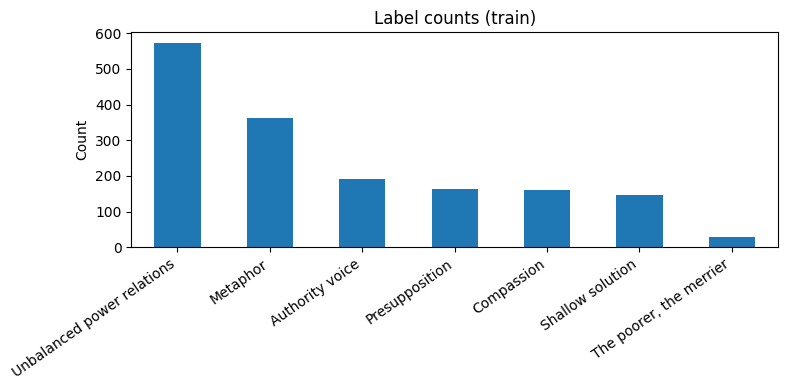

In [14]:
cat_counts = train[cat_cols].sum().astype(int)
cat_counts.index = categories
cat_counts.sort_values(ascending=False)

plt.figure(figsize=(8,4))
cat_counts.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Count")
plt.title("Label counts (train)")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()

### Categories per Example

In [15]:
train["n_cats"] = train[cat_cols].sum(axis=1)
train["n_cats"].value_counts().sort_index()

n_cats
0    7581
1     243
2     335
3     159
4      50
5       7
Name: count, dtype: int64

### Load Test Dataset

In [16]:
def load_test_data(path):
    lines = Path(path).read_text(encoding="utf-8", errors="replace").splitlines()
    data = "\n".join(lines)
    cols = ["par_id","art_id","keyword","country_code","text"]
    return pd.read_csv(io.StringIO(data), sep="\t", names=cols, quoting=3)

test = load_test_data("../data/test_data.tsv")
test.head(), test.shape

(  par_id      art_id     keyword country_code  \
 0    t_0   @@7258997  vulnerable           us   
 1    t_1  @@16397324       women           pk   
 2    t_2  @@16257812     migrant           ca   
 3    t_3   @@3509652     migrant           gb   
 4    t_4    @@477506  vulnerable           ca   
 
                                                 text  
 0  In the meantime , conservatives are working to...  
 1  In most poor households with no education chil...  
 2  The real question is not whether immigration i...  
 3  In total , the country 's immigrant population...  
 4  Members of the church , which is part of Ken C...  ,
 (3832, 5))

## Stage 4: Modelling, training, and hyperparameter sweeps

This section keeps the full implementation in the notebook: data loading, multi-head model, training, dev threshold tuning, a hyperparameter sweep, and final training on the best hyperparameters only.


In [ ]:
import ast
import csv
import itertools
import random
from dataclasses import dataclass, replace
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup

NUM_TAXONOMY_LABELS = 7


@dataclass
class TrainingConfig:
    main_tsv_path: Path
    train_taxonomy_path: Path
    dev_taxonomy_path: Path
    test_tsv_path: Path
    output_dir: Path = Path("artefacts")
    checkpoint_name: str = "best_multitask_model.pt"
    submission_path: Path = Path("submissions/test_predictions.csv")
    primary_model_name: str = "microsoft/deberta-v3-base"
    fallback_model_name: str = "roberta-base"
    batch_size: int = 16
    max_length: int = 256
    num_epochs: int = 5
    learning_rate: float = 2e-5
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    gradient_clip_norm: float = 1.0
    lambda_tax: float = 0.5
    early_stopping_patience: int = 2
    mixed_precision: bool = True
    random_seed: int = 42
    num_workers: int = 0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    @property
    def checkpoint_path(self) -> Path:
        return self.output_dir / self.checkpoint_name


In [ ]:
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def parse_tax_labels(label_text: str) -> np.ndarray:
    if isinstance(label_text, str):
        label_text = label_text.strip()

    try:
        parsed = ast.literal_eval(label_text)
    except (SyntaxError, ValueError, TypeError):
        cleaned = str(label_text).strip().strip("[]")
        parsed = [part.strip() for part in cleaned.split(",") if part.strip()]

    if not isinstance(parsed, (list, tuple)):
        raise ValueError(f"Could not parse taxonomy labels: {label_text}")

    values = np.asarray(parsed, dtype=np.float32)
    if values.shape[0] != NUM_TAXONOMY_LABELS:
        raise ValueError(
            f"Expected {NUM_TAXONOMY_LABELS} taxonomy values, found {values.shape[0]} in {label_text}"
        )
    return values


def load_main_pcl(path: Path) -> pd.DataFrame:
    rows = []
    with path.open("r", encoding="utf-8") as handle:
        reader = csv.reader(handle, delimiter="	")
        for parts in reader:
            if len(parts) < 6:
                continue
            if not parts[0].strip().isdigit():
                continue

            try:
                label_value = int(float(parts[-1].strip()))
            except ValueError:
                continue

            rows.append(
                {
                    "par_id": int(parts[0].strip()),
                    "article_id": parts[1].strip(),
                    "keyword": parts[2].strip(),
                    "country_code": parts[3].strip(),
                    "text": "	".join(parts[4:-1]).strip(),
                    "label": label_value,
                }
            )

    if not rows:
        raise ValueError(f"No valid rows were read from {path}")
    return pd.DataFrame(rows)


def load_taxonomy_split(path: Path) -> pd.DataFrame:
    split_rows = pd.read_csv(path, dtype={"par_id": str, "label": str})
    expected = {"par_id", "label"}
    if not expected.issubset(set(split_rows.columns)):
        raise ValueError(f"Expected columns {expected} in {path}, found {split_rows.columns.tolist()}")

    split_rows["par_id"] = pd.to_numeric(split_rows["par_id"], errors="raise").astype(int)
    split_rows["y_tax"] = split_rows["label"].apply(parse_tax_labels)
    return split_rows.rename(columns={"label": "taxonomy_label_raw"})


def merge_split_text(split_rows: pd.DataFrame, main_rows: pd.DataFrame) -> pd.DataFrame:
    merged = split_rows.merge(
        main_rows[["par_id", "text", "label"]],
        on="par_id",
        how="left",
        validate="one_to_one",
    )

    missing_text_count = int(merged["text"].isna().sum())
    if missing_text_count:
        raise ValueError(f"{missing_text_count} rows have no matching text in main TSV.")

    merged["text"] = merged["text"].fillna("").astype(str)
    merged["y_bin"] = (merged["label"] >= 2).astype(np.float32)
    return merged[["par_id", "text", "y_bin", "y_tax"]].copy()


def load_train_and_dev_data(main_tsv_path: Path, train_taxonomy_path: Path, dev_taxonomy_path: Path):
    main_rows = load_main_pcl(main_tsv_path)
    train_split_rows = load_taxonomy_split(train_taxonomy_path)
    dev_split_rows = load_taxonomy_split(dev_taxonomy_path)

    train_rows = merge_split_text(train_split_rows, main_rows)
    dev_rows = merge_split_text(dev_split_rows, main_rows)
    return train_rows, dev_rows


def load_test_data(path: Path) -> pd.DataFrame:
    rows = []
    with path.open("r", encoding="utf-8") as handle:
        reader = csv.reader(handle, delimiter="	")
        for parts in reader:
            if len(parts) < 5:
                continue

            par_id = parts[0].strip()
            if not par_id or par_id.lower() == "par_id":
                continue

            rows.append(
                {
                    "par_id": par_id,
                    "text": "	".join(parts[4:]).strip(),
                }
            )

    if not rows:
        raise ValueError(f"No valid rows were read from {path}")
    return pd.DataFrame(rows)[["par_id", "text"]].copy()


class PCLDataset(Dataset):
    def __init__(self, input_ids, attention_mask, bin_targets=None, tax_targets=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.bin_targets = bin_targets
        self.tax_targets = tax_targets

    def __len__(self):
        return self.input_ids.shape[0]

    def __getitem__(self, index):
        item = {
            "input_ids": self.input_ids[index],
            "attention_mask": self.attention_mask[index],
        }
        if self.bin_targets is not None and self.tax_targets is not None:
            item["y_bin"] = self.bin_targets[index]
            item["y_tax"] = self.tax_targets[index]
        return item


def build_dataset(rows: pd.DataFrame, tokenizer, max_length: int, include_labels: bool = True):
    encoded = tokenizer(
        rows["text"].fillna("").astype(str).tolist(),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )

    if include_labels:
        bin_targets = torch.tensor(rows["y_bin"].to_numpy(dtype=np.float32), dtype=torch.float32)
        tax_targets = torch.tensor(np.stack(rows["y_tax"].values), dtype=torch.float32)
    else:
        bin_targets = None
        tax_targets = None

    return PCLDataset(
        input_ids=encoded["input_ids"],
        attention_mask=encoded["attention_mask"],
        bin_targets=bin_targets,
        tax_targets=tax_targets,
    )


def build_dataloader(
    rows: pd.DataFrame,
    tokenizer,
    batch_size: int,
    max_length: int,
    shuffle: bool,
    num_workers: int = 0,
    include_labels: bool = True,
):
    dataset = build_dataset(rows, tokenizer, max_length, include_labels)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )


def compute_bin_pos_weight(bin_targets: np.ndarray) -> torch.Tensor:
    positives = float((bin_targets == 1).sum())
    negatives = float((bin_targets == 0).sum())
    if positives == 0:
        return torch.tensor(1.0, dtype=torch.float32)
    return torch.tensor(negatives / positives, dtype=torch.float32)


def binary_metrics(probabilities: np.ndarray, targets: np.ndarray, threshold: float):
    predictions = (probabilities >= threshold).astype(np.int64)
    targets_int = targets.astype(np.int64)

    tp = int(((predictions == 1) & (targets_int == 1)).sum())
    tn = int(((predictions == 0) & (targets_int == 0)).sum())
    fp = int(((predictions == 1) & (targets_int == 0)).sum())
    fn = int(((predictions == 0) & (targets_int == 1)).sum())

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "threshold": float(threshold),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "confusion_matrix": {"tn": tn, "fp": fp, "fn": fn, "tp": tp},
    }


In [ ]:
class MultiHeadPCLModel(nn.Module):
    def __init__(self, encoder_name: str):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        hidden_size = self.encoder.config.hidden_size
        self.binary_head = nn.Linear(hidden_size, 1)
        self.taxonomy_head = nn.Linear(hidden_size, 7)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True,
        )
        pooled = outputs.last_hidden_state[:, 0, :]
        logit_bin = self.binary_head(pooled).squeeze(-1)
        logits_tax = self.taxonomy_head(pooled)
        return logit_bin, logits_tax


def load_tokeniser_and_model(primary_model_name: str, fallback_model_name: str):
    errors = {}
    for model_name in [primary_model_name, fallback_model_name]:
        try:
            tokeniser = AutoTokenizer.from_pretrained(model_name)
            model = MultiHeadPCLModel(model_name)
            return model_name, tokeniser, model
        except Exception as exc:
            errors[model_name] = str(exc)

    details = " | ".join(f"{name}: {message}" for name, message in errors.items())
    raise RuntimeError(f"Could not load either primary or fallback model. Details: {details}")


def eval_on_dev(model, dev_loader, device, binary_loss_fn, taxonomy_loss_fn, lambda_tax: float):
    model.eval()
    running_loss = 0.0
    probabilities = []
    targets = []

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            y_bin = batch["y_bin"].to(device)
            y_tax = batch["y_tax"].to(device)

            logit_bin, logits_tax = model(input_ids=input_ids, attention_mask=attention_mask)
            loss_bin = binary_loss_fn(logit_bin, y_bin)
            loss_tax = taxonomy_loss_fn(logits_tax, y_tax)
            loss = loss_bin + lambda_tax * loss_tax

            running_loss += float(loss.item())
            probabilities.append(torch.sigmoid(logit_bin).detach().cpu().numpy())
            targets.append(y_bin.detach().cpu().numpy())

    prob_array = np.concatenate(probabilities)
    target_array = np.concatenate(targets)
    metrics = binary_metrics(prob_array, target_array, threshold=0.5)
    avg_loss = running_loss / max(1, len(dev_loader))

    return {
        "loss": avg_loss,
        "probabilities": prob_array,
        "targets": target_array,
        "metrics_at_0_5": metrics,
    }


def train_model(
    model,
    train_loader,
    dev_loader,
    config: TrainingConfig,
    pos_weight: torch.Tensor,
    checkpoint_path: Path,
    model_name: str,
):
    device = torch.device(config.device)
    model.to(device)

    binary_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    taxonomy_loss_fn = nn.BCEWithLogitsLoss()
    optimiser = AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    total_steps = max(1, config.num_epochs * len(train_loader))
    warmup_steps = int(config.warmup_ratio * total_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimiser,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    amp_enabled = config.mixed_precision and device.type == "cuda"
    scaler = GradScaler(enabled=amp_enabled)

    best_dev_f1 = -1.0
    best_epoch = 0
    stale_epochs = 0
    history = []

    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

    for epoch in range(1, config.num_epochs + 1):
        model.train()
        running_train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{config.num_epochs}", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            y_bin = batch["y_bin"].to(device)
            y_tax = batch["y_tax"].to(device)

            optimiser.zero_grad(set_to_none=True)
            with autocast(enabled=amp_enabled):
                logit_bin, logits_tax = model(input_ids=input_ids, attention_mask=attention_mask)
                loss_bin = binary_loss_fn(logit_bin, y_bin)
                loss_tax = taxonomy_loss_fn(logits_tax, y_tax)
                loss = loss_bin + config.lambda_tax * loss_tax

            scaler.scale(loss).backward()
            scaler.unscale_(optimiser)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip_norm)
            scaler.step(optimiser)
            scaler.update()
            scheduler.step()

            running_train_loss += float(loss.item())

        avg_train_loss = running_train_loss / max(1, len(train_loader))
        dev_eval = eval_on_dev(model, dev_loader, device, binary_loss_fn, taxonomy_loss_fn, config.lambda_tax)

        dev_metrics = dev_eval["metrics_at_0_5"]
        history.append(
            {
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "dev_loss": dev_eval["loss"],
                "dev_precision_at_0_5": dev_metrics["precision"],
                "dev_recall_at_0_5": dev_metrics["recall"],
                "dev_f1_at_0_5": dev_metrics["f1"],
            }
        )

        print(
            f"Epoch {epoch:02d} | train_loss={avg_train_loss:.4f} | "
            f"dev_loss={dev_eval['loss']:.4f} | dev_f1@0.5={dev_metrics['f1']:.4f}"
        )

        if dev_metrics["f1"] > best_dev_f1:
            best_dev_f1 = dev_metrics["f1"]
            best_epoch = epoch
            stale_epochs = 0
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "model_name": model_name,
                    "best_dev_f1": best_dev_f1,
                    "best_epoch": best_epoch,
                },
                checkpoint_path,
            )
        else:
            stale_epochs += 1
            if stale_epochs >= config.early_stopping_patience:
                print(f"Early stopping at epoch {epoch:02d}.")
                break

    return {
        "history": history,
        "best_dev_f1_at_0_5": best_dev_f1,
        "best_epoch": best_epoch,
        "checkpoint_path": str(checkpoint_path),
    }


def tune_threshold(
    probabilities: np.ndarray,
    targets: np.ndarray,
    start: float = 0.05,
    end: float = 0.95,
    step: float = 0.01,
):
    thresholds = np.round(np.arange(start, end + 1e-9, step), 2)
    metrics_at_0_5 = binary_metrics(probabilities, targets, threshold=0.5)

    best_threshold = 0.5
    best_metrics = metrics_at_0_5

    for threshold in thresholds:
        metrics = binary_metrics(probabilities, targets, threshold=float(threshold))
        if metrics["f1"] > best_metrics["f1"]:
            best_threshold = float(threshold)
            best_metrics = metrics

    return {
        "best_threshold": best_threshold,
        "metrics_at_0_5": metrics_at_0_5,
        "metrics_at_best_threshold": best_metrics,
    }


def predict_binary_probabilities(model, data_loader, device: torch.device, return_targets: bool = False):
    model.eval()
    probabilities = []
    targets = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            logit_bin, _ = model(input_ids=input_ids, attention_mask=attention_mask)

            probabilities.append(torch.sigmoid(logit_bin).detach().cpu().numpy())
            if return_targets and "y_bin" in batch:
                targets.append(batch["y_bin"].detach().cpu().numpy())

    prob_array = np.concatenate(probabilities)
    target_array = np.concatenate(targets) if targets else None
    return prob_array, target_array


def write_test_predictions(par_ids, probabilities: np.ndarray, threshold: float, output_path: Path):
    predictions = (probabilities >= threshold).astype(int)
    output_rows = pd.DataFrame({"par_id": par_ids, "label": predictions})
    output_path.parent.mkdir(parents=True, exist_ok=True)
    output_rows.to_csv(output_path, index=False)
    return output_path


def run_training_and_inference(config: TrainingConfig, write_submission: bool = True):
    set_seed(config.random_seed)
    device = torch.device(config.device)

    train_rows, dev_rows = load_train_and_dev_data(
        main_tsv_path=Path(config.main_tsv_path),
        train_taxonomy_path=Path(config.train_taxonomy_path),
        dev_taxonomy_path=Path(config.dev_taxonomy_path),
    )

    loaded_model_name, tokenizer, model = load_tokeniser_and_model(
        primary_model_name=config.primary_model_name,
        fallback_model_name=config.fallback_model_name,
    )

    train_loader = build_dataloader(
        rows=train_rows,
        tokenizer=tokenizer,
        batch_size=config.batch_size,
        max_length=config.max_length,
        shuffle=True,
        num_workers=config.num_workers,
        include_labels=True,
    )
    dev_loader = build_dataloader(
        rows=dev_rows,
        tokenizer=tokenizer,
        batch_size=config.batch_size,
        max_length=config.max_length,
        shuffle=False,
        num_workers=config.num_workers,
        include_labels=True,
    )

    pos_weight = compute_bin_pos_weight(train_rows["y_bin"].to_numpy(dtype=np.float32))
    training_summary = train_model(
        model=model,
        train_loader=train_loader,
        dev_loader=dev_loader,
        config=config,
        pos_weight=pos_weight,
        checkpoint_path=Path(config.checkpoint_path),
        model_name=loaded_model_name,
    )

    checkpoint = torch.load(Path(config.checkpoint_path), map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)

    dev_probabilities, dev_targets = predict_binary_probabilities(
        model=model,
        data_loader=dev_loader,
        device=device,
        return_targets=True,
    )
    if dev_targets is None:
        raise RuntimeError("Dev targets were not returned. This should not happen.")

    threshold_summary = tune_threshold(
        probabilities=dev_probabilities,
        targets=dev_targets,
        start=0.05,
        end=0.95,
        step=0.01,
    )

    test_size = 0
    submission_path = None

    if write_submission:
        test_rows = load_test_data(Path(config.test_tsv_path))
        test_loader = build_dataloader(
            rows=test_rows,
            tokenizer=tokenizer,
            batch_size=config.batch_size,
            max_length=config.max_length,
            shuffle=False,
            num_workers=config.num_workers,
            include_labels=False,
        )
        test_probabilities, _ = predict_binary_probabilities(
            model=model,
            data_loader=test_loader,
            device=device,
            return_targets=False,
        )
        output_path = write_test_predictions(
            par_ids=test_rows["par_id"].tolist(),
            probabilities=test_probabilities,
            threshold=threshold_summary["best_threshold"],
            output_path=Path(config.submission_path),
        )
        test_size = int(len(test_rows))
        submission_path = str(output_path)

    return {
        "loaded_model_name": loaded_model_name,
        "device": str(device),
        "train_size": int(len(train_rows)),
        "dev_size": int(len(dev_rows)),
        "test_size": test_size,
        "training_summary": training_summary,
        "threshold_summary": threshold_summary,
        "submission_path": submission_path,
    }


def iter_sweep_settings(sweep_space: dict):
    keys = list(sweep_space.keys())
    value_lists = [sweep_space[key] for key in keys]
    for combo in itertools.product(*value_lists):
        yield dict(zip(keys, combo))


def run_hyperparameter_sweep(
    base_config: TrainingConfig,
    sweep_space: dict,
    sweep_dir: Path,
    max_trials: int | None = None,
):
    all_trials = list(iter_sweep_settings(sweep_space))
    rng = random.Random(base_config.random_seed)
    rng.shuffle(all_trials)

    if max_trials is not None:
        all_trials = all_trials[:max_trials]

    if not all_trials:
        raise ValueError("No hyperparameter trials were created. Check sweep_space.")

    sweep_dir.mkdir(parents=True, exist_ok=True)
    trial_rows = []
    best_params = None
    best_score = -1.0

    total_trials = len(all_trials)
    print(f"Running {total_trials} hyperparameter trials")

    for trial_index, trial_params in enumerate(all_trials, start=1):
        trial_name = f"trial_{trial_index:03d}"
        trial_output_dir = sweep_dir / trial_name

        trial_config = replace(base_config, output_dir=trial_output_dir, **trial_params)

        print(f"\nTrial {trial_index}/{total_trials}: {trial_params}")
        trial_results = run_training_and_inference(trial_config, write_submission=False)

        tuned_metrics = trial_results["threshold_summary"]["metrics_at_best_threshold"]
        metrics_at_0_5 = trial_results["threshold_summary"]["metrics_at_0_5"]
        tuned_f1 = float(tuned_metrics["f1"])

        row = {
            "trial": trial_name,
            **trial_params,
            "dev_f1_tuned": tuned_f1,
            "dev_precision_tuned": float(tuned_metrics["precision"]),
            "dev_recall_tuned": float(tuned_metrics["recall"]),
            "best_threshold": float(trial_results["threshold_summary"]["best_threshold"]),
            "dev_f1_at_0_5": float(metrics_at_0_5["f1"]),
            "best_epoch": int(trial_results["training_summary"]["best_epoch"]),
            "checkpoint_path": trial_results["training_summary"]["checkpoint_path"],
        }
        trial_rows.append(row)

        if tuned_f1 > best_score:
            best_score = tuned_f1
            best_params = dict(trial_params)

    sweep_table = pd.DataFrame(trial_rows).sort_values(
        ["dev_f1_tuned", "dev_f1_at_0_5"],
        ascending=False,
    ).reset_index(drop=True)

    sweep_results_path = sweep_dir / "sweep_results.csv"
    sweep_table.to_csv(sweep_results_path, index=False)

    if best_params is None:
        raise RuntimeError("No best trial was selected.")

    return {
        "results_table": sweep_table,
        "results_path": str(sweep_results_path),
        "best_params": best_params,
    }


In [ ]:
if Path.cwd().name == "BestModel":
    project_root = Path.cwd().parent.resolve()
else:
    project_root = Path.cwd().resolve()

base_config = TrainingConfig(
    main_tsv_path=project_root / "data" / "dontpatronizeme_pcl.tsv",
    train_taxonomy_path=project_root / "data" / "train_data.csv",
    dev_taxonomy_path=project_root / "data" / "dev_data.csv",
    test_tsv_path=project_root / "data" / "test_data.tsv",
    output_dir=project_root / "artefacts",
    submission_path=project_root / "submissions" / "test_predictions.csv",
    batch_size=16,
    max_length=256,
    lambda_tax=0.5,
    num_epochs=5,
    early_stopping_patience=2,
)

sweep_space = {
    "batch_size": [8, 16],
    "max_length": [192, 256],
    "learning_rate": [1e-5, 2e-5, 3e-5],
    "weight_decay": [0.0, 0.01],
    "warmup_ratio": [0.06, 0.1],
    "gradient_clip_norm": [0.8, 1.0],
    "lambda_tax": [0.3, 0.5, 0.7],
    "num_epochs": [4, 5],
    "early_stopping_patience": [2, 3],
}

max_sweep_trials = 30

sweep_dir = project_root / "artefacts" / "hyperparameter_sweep"
sweep_output = run_hyperparameter_sweep(
    base_config=base_config,
    sweep_space=sweep_space,
    sweep_dir=sweep_dir,
    max_trials=max_sweep_trials,
)

sweep_table = sweep_output["results_table"]
best_params = sweep_output["best_params"]

print(f"Sweep results saved to: {sweep_output['results_path']}")
print("\nTop sweep trials")
print(sweep_table.head(10).to_string(index=False))

print("\nBest hyperparameters")
print(best_params)

tuned_config = replace(
    base_config,
    output_dir=project_root / "artefacts" / "best_tuned_run",
    **best_params,
)

final_results = run_training_and_inference(tuned_config, write_submission=True)
final_threshold = final_results["threshold_summary"]
metrics_at_0_5 = final_threshold["metrics_at_0_5"]
metrics_at_tuned = final_threshold["metrics_at_best_threshold"]

print(f"\nLoaded model: {final_results['loaded_model_name']}")
print(f"Best dev threshold: {final_threshold['best_threshold']:.2f}")

print("\nFinal dev metrics at tau=0.50")
print(f"Precision: {metrics_at_0_5['precision']:.4f}")
print(f"Recall:    {metrics_at_0_5['recall']:.4f}")
print(f"F1:        {metrics_at_0_5['f1']:.4f}")

print("\nFinal dev metrics at tuned tau")
print(f"Precision: {metrics_at_tuned['precision']:.4f}")
print(f"Recall:    {metrics_at_tuned['recall']:.4f}")
print(f"F1:        {metrics_at_tuned['f1']:.4f}")

print("\nFinal confusion matrix at tuned tau")
print(metrics_at_tuned["confusion_matrix"])

print(f"\nTest predictions written to: {final_results['submission_path']}")
final_results
